# Data source

The data for this notebook is pulled from https://www.alltime-athletics.com/m_100ok.htm and https://en.wikipedia.org/wiki/List_of_doping_cases_in_athletics

Unfortunately, the 100m data is not provided in any downloadable format, so I have just copied their table to `mens-100m.txt`.

Neither the 100m data nor the doping data is intended to be definitive proof or an exhaustive list, this is just a little side project to sate my curiosity.

# Converting to CSV for future convenience

In [1]:
import os
import re

def insert_placeholders(row):  
    # place
    if len(row) == 0 or not re.fullmatch('\d+', row[0]):
        row.insert(0, 'NaN')    
    # time
    if len(row) == 1 or not re.fullmatch('\d+\.\d+A?', row[1]):
        row.insert(1, 'NaN')
    # wind
    if len(row) == 2 or not re.fullmatch('(\+|-|±)?\d+\.\d+', row[2]):
        row.insert(2, 'NaN')
    # name
    if len(row) == 3 or not re.fullmatch('[\w\s\.]+', row[3]):
        row.insert(3, 'Unknown')    
    # country
    if len(row) == 4 or not re.fullmatch('[A-Z]{3}', row[4]):
        row.insert(4, 'Unknown')
    # birthday
    if len(row) == 5 or not re.fullmatch('\d{2}\.\d{2}\.\d{2}', row[5]):
        row.insert(5, 'Unknown')
    # placement
    if len(row) == 6 or not re.fullmatch('(\d+)|(\d+\w\d+)', row[6]):
        row.insert(6, 'Unknown')    
    # city
    if len(row) == 7 or not re.match('[\w\s]+', row[7]):
        row.insert(7, 'Unknown')    
    # date
    if len(row) == 8 or not re.fullmatch('\d{2}\.\d{2}\.\d{4}', row[8]):
        row.insert(8, 'Unknown')

def create_csv(input_path, output_path):
    processed_lines = []
    with open(input_path, 'r') as data:
        for line in data:
            line = line.strip()
            columns = re.split(r'\s{2,}', line)
            if len(columns) != 9:
                insert_placeholders(columns)
            
            processed_lines.append('"' + '","'.join(columns) + '"')
    
    with open(output_path, 'w') as file:
        file.write('\n'.join(processed_lines))

ALWAYS_REMAKE = True
input_path = 'mens-100m.txt'
output_path = 'mens-100m.csv'
if ALWAYS_REMAKE or not os.path.isfile(output_path):
    print('Creating CSV File...')
    create_csv(input_path, output_path)

Creating CSV File...


# Loading the data

In [2]:
import pandas as pd

top_sprinters = pd.read_csv('mens-100m.csv', header=None, quotechar='"')
top_sprinters.columns = ['Ranking', 'Time', 'Wind', 'Name', 'Country', 'Birthdate', 'Place', 'City', 'Date']
top_sprinters.head()

,Ranking,Time,Wind,Name,Country,Birthdate,Place,City,Date
0,1,9.58,+0.9,Usain Bolt,JAM,21.08.86,1,Berlin,16.08.2009
1,2,9.63,+1.5,Usain Bolt,JAM,21.08.86,1,London,05.08.2012
2,3,9.69,±0.0,Usain Bolt,JAM,21.08.86,1,Beijing,16.08.2008
3,3,9.69,+2.0,Tyson Gay,USA,09.08.82,1,Shanghai,20.09.2009
4,3,9.69,-0.1,Yohan Blake,JAM,26.12.89,1,Lausanne,23.08.2012


In [3]:
doping_cases = pd.read_csv('List of doping cases.csv')
doping_cases.head()

,Name,Country,Event,Date of violation,Banned substance(s)/Anti-doping rule violation,Sanction,Reference(s)
0,Ahmed Abd El Raouf,Egypt,Hammer throw,2008,Norandrosterone,2 years,[2][3]
1,Inga Abitova,Russia,Long distance,2009,Biological passport anomalies,2 years,[4][5][6]
2,Folashade Abugan,Nigeria,Sprinting,2010,Testosterone prohormone,2 years,[7][8][9]
3,Ibrahim Mohamed Aden,Somalia,Middle distance,1999,Ephedrine,Public warning,[10][11][12]
4,Tosin Adeloye,Nigeria,Sprinting,2012\n2015,Metenolone\nExogenous steroids,2 years\n8 years,[13][14]\n[15][16]


# Creating list of sprinters

In [4]:
doping_sprinters = doping_cases[doping_cases['Event'] == 'Sprinting']['Name'].unique()

# TODO handle alternate names
print([name for name in doping_sprinters if bool(re.search(r'[^\w\s-]', name))])

['Yekaterina Grigoryeva\n(Yekaterina Leshcheva)', 'Gloria Kemasuode\n(Gloria Ubiebor)']


# Combining data
This stage is not currently necessary with how I am generating the table. Depending on how I finish the table generation, this may be removed.

In [5]:
doped_or_not = []
for index, row in top_sprinters.iterrows():
    entry = {'Place': row['Place'], 'Time': row['Time'], 'Name': row['Name'], 'Country': row['Country'], 'Date': row['Date']}
    entry['Doped'] = row['Name'] in doping_sprinters
    doped_or_not.append(entry)

doped_or_not = pd.DataFrame(doped_or_not)
doped_or_not.head()

,Place,Time,Name,Country,Date,Doped
0,1,9.58,Usain Bolt,JAM,16.08.2009,False
1,1,9.63,Usain Bolt,JAM,05.08.2012,False
2,1,9.69,Usain Bolt,JAM,16.08.2008,False
3,1,9.69,Tyson Gay,USA,20.09.2009,True
4,1,9.69,Yohan Blake,JAM,23.08.2012,True


# Generating a table

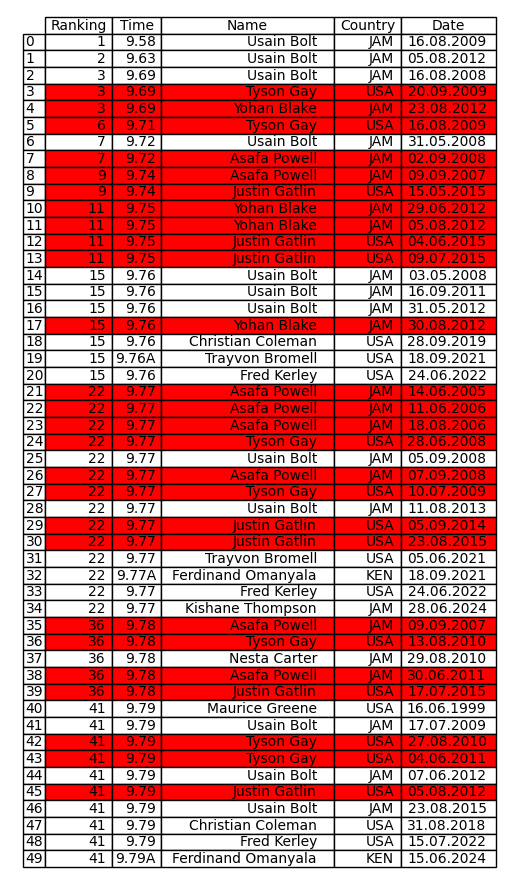

In [6]:
import matplotlib.pylab as plt
from pandas.plotting import table

# drop some columns to simplify display
sub_frame = top_sprinters.drop(columns=['Wind', 'Birthdate', 'Place', 'City'])[:50]
sub_frame.head()

fig, ax = plt.subplots()

# remove some bloat from the display
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

tab = table(ax, sub_frame, loc='upper right')

# making sure that columns don't overflow into the next cell
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.auto_set_column_width(col=list(range(len(sub_frame.columns)))) 

# highlight known dopers
for index, row in sub_frame.iterrows():
    if row['Name'] in doping_sprinters:
        for col in range(sub_frame.shape[1]):
            tab[index + 1, col].set_facecolor("red")

plt.savefig('table.png')